<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    Libraries
</p>

In [1]:
from torch import nn
import numpy as np
import datetime
import torch
import cv2
import gym
import os
from time import sleep
import pathlib
import matplotlib.pyplot as plt
import random
from collections import deque

<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    Main
</p>

In [1]:
from torch import nn
import numpy as np
import datetime
import torch
import cv2
import gym
import os
from time import sleep
import pathlib
import matplotlib.pyplot as plt


class HumanPref(nn.Module):
    def __init__(self, obs_size, neuron_size=64):
        super(HumanPref, self).__init__()

        self.obs_size = obs_size
        self.neuron_size = neuron_size

        self.dense1 = nn.Linear(self.obs_size, self.neuron_size)
        self.dense2 = nn.Linear(self.neuron_size, 1)

        self.batch_norm = nn.BatchNorm1d(1)

    def forward(self, x1, x2=None):

        model1_couche1 = self.dense1(x1)
        model1_couche2 = torch.nn.functional.relu(model1_couche1)
        model1_couche3 = self.dense2(model1_couche2)
        model1_couche4 = self.batch_norm(model1_couche3)
        if x2 is None:
            return model1_couche4
        else:
            model2_couche1 = self.dense1(x2)
            model2_couche2 = torch.nn.functional.relu(model2_couche1)
            model2_couche3 = self.dense2(model2_couche2)
            model2_couche4 = self.batch_norm(model2_couche3)
            # output = nn.functional.softmax(torch.stack([model1_couche4, model2_couche4]), dim=0)
            p1_sum = torch.exp(torch.sum(model1_couche1)/len(x1))
            p2_sum = torch.exp(torch.sum(model2_couche4)/len(x2))
            p1 = p1_sum/torch.add(p1_sum, p2_sum)
            p2 = p2_sum / torch.add(p1_sum, p2_sum)
            return torch.stack([p1, p2])


class HumanPreference(object):
    def __init__(self, obs_size, action_size):
        self.trijectories = []
        self.preferences = []
        self.layer_count = 3
        self.neuron_size_init = 64
        self.batch_size_init = 10
        self.learning_rate = 0.00025
        self.obs_size = obs_size
        self.action_size = action_size
        self.neuron_size = obs_size ** 3
        self.loss_l = []

        self.create_model()

    def create_model(self):
        self.model = HumanPref(self.obs_size, self.neuron_size)
        self.criterion = nn.functional.binary_cross_entropy
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self):
        self.model.train()
        if len(self.preferences) < 5:
            return

        batch_size = min(len(self.preferences), self.batch_size_init)
        r = np.asarray(range(len(self.preferences)))
        np.random.shuffle(r)

        min_loss = 1e+10
        max_loss = -1e+10
        lo = 0.0
        for i in r[:batch_size]:
            x0, x1, preference = self.preferences[i]

            pref_dist = np.zeros([2], dtype=np.float32)
            if preference < 2:
                pref_dist[preference] = 1.0
            else:
                pref_dist[:] = 0.5

            x0 = torch.from_numpy(np.asarray(x0)).float()
            x1 = torch.from_numpy(np.asarray(x1)).float()
            y = torch.from_numpy(pref_dist)
            y_hat = self.model(x0, x1)

            loss = self.criterion(y_hat, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if loss.item() > max_loss:
                max_loss = loss.item()
            elif loss.item() < min_loss:
                min_loss = loss.item()

            lo = loss.item()
        print("[ Loss: actual loss =", lo, " max =", max_loss, " min =", min_loss, "]")

        self.loss_l.append(lo)

    def predict(self, obs):
        self.model.eval()
        obs = torch.tensor([obs]).float()
        pred = self.model(obs)
        return pred.detach().numpy()

    def add_preference(self, o0, o1, preference):
        self.preferences.append([o0, o1, preference])

    def add_trijactory(self, trijectory_env_name,  trijectory):
        self.trijectories.append([trijectory_env_name, trijectory])

    def ask_human(self):

        if len(self.trijectories) < 2:
            return

        r = np.asarray(range(len(self.trijectories)))
        np.random.shuffle(r)
        t = [self.trijectories[r[0]], self.trijectories[r[1]]]

        envs = []
        for i in range(len(t)):
            env_name, trijectory = t[i]
            env = gym.make(env_name)
            env.reset()
            env.render()
            envs.append(env)

        cv2.imshow("", np.zeros([1, 1], dtype=np.uint8))

        print("Preference (1,2|3):")
        env_idxs = np.zeros([2], dtype=np.int32)
        preference = -1
        while True:
            key = cv2.waitKey(1) & 0xFF
            if key == ord('1'):
                preference = 0
            elif key == ord('2'):
                preference = 1
            elif key == ord('3') or key == ord('0'):
                preference = 2

            if preference != -1:
                break

            for i in range(len(t)):
                envs[i].render()

                env_name, trijectory = t[i]
                obs, future_obs, action, done = trijectory[env_idxs[i]]
                envs[i].step(action)
                env_idxs[i] += 1
                if done or env_idxs[i] >= len(trijectory):
                    envs[i].reset()
                    env_idxs[i] = 0
            sleep(0.02)

        if preference != -1:
            os = []
            for i in range(len(t)):
                env_name, trijectory = t[i]
                o = []

                for j in range(len(trijectory)):
                    o.append(trijectory[j][1])

                os.append(o)

            self.add_preference(os[0], os[1], preference)

        cv2.destroyAllWindows()
        for i in range(len(envs)):
            envs[i].close()

        if preference == 0:
            print(1)
        elif preference == 1:
            print(2)
        elif preference != -1:
            print("neutral")
        else:
            print("no oppinion")


    def plot(self):
        x = np.arange(0, len(self.loss_l))
        y = np.asarray(self.loss_l)
        fig, ax = plt.subplots()
        ax.plot(y)
        ax.set_xlabel('epochs')
        ax.set_ylabel('loss')
        ax.set_title('Loss per epochs')

        # datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # path = os.path.join(pathlib.Path().absolute(), 'plots', 'hp_model', 'hp_model' + datetime_str + ".png")
        # plt.savefig(path)

Run: 1, exploration: 1.0, score: 10
Run: 2, exploration: 0.9322301194154049, score: 24
Run: 3, exploration: 0.8734200960253871, score: 14
Run: 4, exploration: 0.8020760579717637, score: 18
Run: 5, exploration: 0.6900935609921609, score: 31
Preference (1,2|3):


c:\Users\salem\miniconda3\envs\data\lib\site-packages\gym\envs\classic_control\cartpole.py:177: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


1
Run: 6, exploration: 0.6498078359349755, score: 13
Run: 7, exploration: 0.5907768628656763, score: 20
Run: 8, exploration: 0.5425201222922789, score: 18
Run: 9, exploration: 0.5082950737585841, score: 14
Run: 10, exploration: 0.4439551321314536, score: 28
Preference (1,2|3):
neutral
Run: 11, exploration: 0.4222502236424958, score: 11
Run: 12, exploration: 0.40769130904675194, score: 8
Run: 13, exploration: 0.3897078735047413, score: 10
Run: 14, exploration: 0.3706551064126331, score: 11
Run: 15, exploration: 0.3507711574848344, score: 12
Preference (1,2|3):
2
Run: 16, exploration: 0.33195389135223546, score: 12
Run: 17, exploration: 0.3157247089126454, score: 11
Run: 18, exploration: 0.2987875242397482, score: 12
Run: 19, exploration: 0.2507092085103961, score: 36
Run: 20, exploration: 0.23607350863684065, score: 13
Preference (1,2|3):
neutral
Run: 21, exploration: 0.20826882814336947, score: 26
Run: 22, exploration: 0.19908200231898848, score: 10
Run: 23, exploration: 0.191256694728

C:\Users\salem\AppData\Local\Temp\ipykernel_24696\3595392194.py:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  obs = torch.tensor([obs]).float()


Preference (1,2|3):
neutral
[ Loss: actual loss = 2.3496787548065186  max = 3.596831798553467  min = 0.009152865968644619 ]
Run: 26, exploration: 0.1580861105294992, score: 10
Run: 27, exploration: 0.14885748713096328, score: 13
Run: 28, exploration: 0.09770335251664321, score: 85
Run: 29, exploration: 0.07915509187866444, score: 43
Run: 30, exploration: 0.0543512971290831, score: 76
Preference (1,2|3):
2
[ Loss: actual loss = 0.6704575419425964  max = 3.5484108924865723  min = 0.6704575419425964 ]
Run: 31, exploration: 0.04537752660798141, score: 37
Run: 32, exploration: 0.03325613897196732, score: 63
Run: 33, exploration: 0.023297566459620722, score: 72
Run: 34, exploration: 0.01964695745288379, score: 35
Run: 35, exploration: 0.017332943577287888, score: 26
Preference (1,2|3):
neutral
[ Loss: actual loss = 0.7700028419494629  max = 3.466428279876709  min = 0.011098472401499748 ]
Run: 36, exploration: 0.01575835418494799, score: 20
Run: 37, exploration: 0.01476423357148172, score: 14

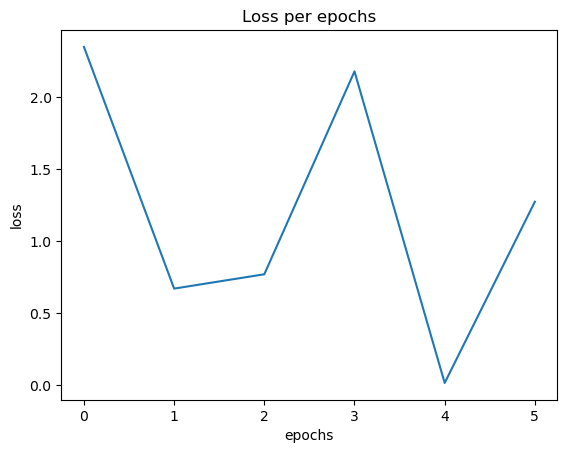

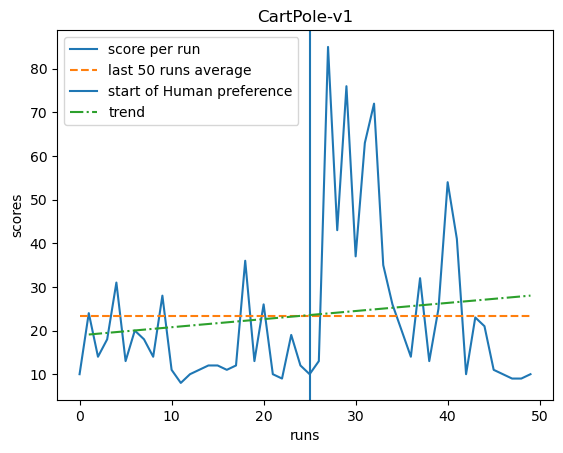

In [2]:
import random
import gym
import numpy as np
from collections import deque
import os
import matplotlib.pyplot as plt
import datetime
import pathlib
import torch
from torch import nn

mode = "Human"  # "Human" pour avoir les préférences humaines sur les rewards, "self" pour avoir les rewards par défaut
ENV_NAME = "CartPole-v1"

GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

CONSECUTIVE_RUNS_TO_SOLVE = 100


class NN(nn.Module):
    def __init__(self, obs_size, action_size):
        super(NN, self).__init__()
        self.dense1 = nn.Linear(obs_size, 24)
        self.dense2 = nn.Linear(24, 24)
        self.dense3 = nn.Linear(24, 24)
        self.dense4 = nn.Linear(24, action_size)

    def forward(self, x):
        l1 = self.dense1(x)
        l2 = nn.functional.relu(l1)
        l3 = self.dense2(l2)
        l4 = nn.functional.relu(l3)
        l5 = self.dense3(l4)
        l6 = nn.functional.relu(l5)
        output = self.dense4(l6)
        return output


class DQNSolver:

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.scores = deque(maxlen=CONSECUTIVE_RUNS_TO_SOLVE)

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.rl_model = NN(observation_space, action_space)

        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.rl_model.parameters(), lr=LEARNING_RATE)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.rl_model(torch.tensor(state).float()).detach().numpy()
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_pred = self.rl_model(torch.tensor(state_next).float()).detach().numpy()
                q_update = (reward + GAMMA * np.amax(q_pred))
            q_values = self.rl_model(torch.tensor(state).float()).detach().numpy()
            q_values[0][action] = q_update

            x = torch.from_numpy(state).float()
            y = torch.from_numpy(q_values).float()

            y_hat = self.rl_model(x)
            loss = self.criterion(y_hat, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()     # TODO
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def add_score(self, score):
        self.scores.append(score)

    def plot_score(self, mode, episodes):

        data = np.array(self.scores)
        x = []
        y = []
        x_label = "runs"
        y_label = "scores"
        for i in range(0, len(data)):
            x.append(int(i))
            y.append(int(data[i]))

        plt.subplots()
        plt.plot(x, y, label="score per run")

        average_range = len(x)
        plt.plot(x[-average_range:], [np.mean(y[-average_range:])] * len(y[-average_range:]), linestyle="--",
                 label="last " + str(average_range) + " runs average")

        if mode == "Human":
            plt.axvline(x=episodes/2, label="start of Human preference")

        if len(x) > 1:
            trend_x = x[1:]
            z = np.polyfit(np.array(trend_x), np.array(y[1:]), 1)
            p = np.poly1d(z)
            plt.plot(trend_x, p(trend_x), linestyle="-.", label="trend")

        plt.title(ENV_NAME)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        plt.legend(loc="upper left")
        plt.show()
        # datetime_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        # path = os.path.join(pathlib.Path().absolute(), 'plots', 'dqn', 'dqn_score_' + mode + '_' + datetime_str + ".png")
        # plt.savefig(path, bbox_inches="tight")
        # plt.close()


def cartpole():
    env = gym.make(ENV_NAME)
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n
    dqn_solver = DQNSolver(observation_space, action_space)
    hp_model = HumanPreference(observation_space, action_space)
    run = 0
    episodes = 50
    for i in range(episodes):
        run += 1
        state = env.reset()
        state = np.reshape(state[0], [1, observation_space])
        step = 0
        trijectory = []
        while True:
            step += 1
            # env.render()
            action = dqn_solver.act(state)
            state_next, reward, terminal, info = env.step(action)[:4]
            if mode == "self" or run < episodes / 2:
                reward = reward if not terminal else -reward
            else:
                reward = hp_model.predict(state_next)
            state_next = np.reshape(state_next, [1, observation_space])
            dqn_solver.remember(state, action, reward, state_next, terminal)
            trijectory.append([state, state_next, action, terminal])
            state = state_next
            if terminal:
                print(
                    "Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
                hp_model.add_trijactory(ENV_NAME, trijectory)
                dqn_solver.add_score(step)
                break
            dqn_solver.experience_replay()

        if run % 5 == 0 and mode == "Human":
            hp_model.ask_human()
            hp_model.train()

    if mode == "Human":
        hp_model.plot()
    dqn_solver.plot_score(mode, episodes)


if __name__ == "__main__":
    cartpole()

<p style="background-color:#CC9911;text-align:center;vertical-align: middle;padding:30px;font-family:courier;font-size:30px;color:black">
    A3C rl_teacher_Pytorch
</p>

In [1]:
#a3c_model
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


def normalized_columns_initializer(weights, std=1.0):
    out = torch.randn(weights.size())
    out *= std / torch.sqrt(out.pow(2).sum(1, keepdim=True))
    return out


def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = np.prod(weight_shape[1:4])
        fan_out = np.prod(weight_shape[2:4]) * weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)
    elif classname.find('Linear') != -1:
        weight_shape = list(m.weight.data.size())
        fan_in = weight_shape[1]
        fan_out = weight_shape[0]
        w_bound = np.sqrt(6. / (fan_in + fan_out))
        m.weight.data.uniform_(-w_bound, w_bound)
        m.bias.data.fill_(0)


class ActorCritic(torch.nn.Module):
    def __init__(self, num_inputs, action_space):
        super(ActorCritic, self).__init__()
        self.conv1 = nn.Conv2d(num_inputs, 32, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, stride=2, padding=1)

        self.lstm = nn.LSTMCell(32 * 3 * 3, 256)

        num_outputs = action_space.n
        self.critic_linear = nn.Linear(256, 1)
        self.actor_linear = nn.Linear(256, num_outputs)

        self.apply(weights_init)
        self.actor_linear.weight.data = normalized_columns_initializer(
            self.actor_linear.weight.data, 0.01)
        self.actor_linear.bias.data.fill_(0)
        self.critic_linear.weight.data = normalized_columns_initializer(
            self.critic_linear.weight.data, 1.0)
        self.critic_linear.bias.data.fill_(0)

        self.lstm.bias_ih.data.fill_(0)
        self.lstm.bias_hh.data.fill_(0)

        self.train()

    def forward(self, inputs):
        inputs, (hx, cx) = inputs
        x = F.elu(self.conv1(inputs))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        x = x.view(-1, 32 * 3 * 3)
        hx, cx = self.lstm(x, (hx, cx))
        x = hx

        return self.critic_linear(x), self.actor_linear(x), (hx, cx)

In [2]:
# envs.py
import cv2
import gym
import numpy as np
from gym.spaces.box import Box


# Taken from https://github.com/openai/universe-starter-agent
def create_atari_env(env_id):
    env = gym.make(env_id)
    env = AtariRescale42x42(env)
    env = NormalizedEnv(flip=False, env=env)
    # env = HumanWrapper(env)
    return env


def _process_frame42(frame):
    frame = frame[34:34 + 160, :160]
    # Resize by half, then down to 42x42 (essentially mipmapping). If
    # we resize directly we lose pixels that, when mapped to 42x42,
    # aren't close enough to the pixel boundary.
    frame = cv2.resize(frame, (80, 80))
    frame = cv2.resize(frame, (42, 42))
    frame = frame.mean(2, keepdims=True)
    frame = frame.astype(np.float32)
    frame *= (1.0 / 255.0)
    frame = np.moveaxis(frame, -1, 0)
    return frame

# class HumanWrapper(gym.ObservationWrapper):
#     def __init__(self, env, flip=False):
#         super(HumanWrapper, self).__init__(env)
#         self.flip = flip
        
    

class AtariRescale42x42(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(AtariRescale42x42, self).__init__(env)
        self.observation_space = Box(0.0, 1.0, [1, 42, 42])

    def _observation(self, observation):
        return _process_frame42(observation)


class NormalizedEnv(gym.ObservationWrapper):
    def __init__(self, flip, env=None):
        super(NormalizedEnv, self).__init__(env)
        self.state_mean = 0
        self.state_std = 0
        self.alpha = 0.9999
        self.num_steps = 0
        self.flip = flip

    def _observation(self, observation):
        self.num_steps += 1
        self.state_mean = self.state_mean * self.alpha + \
            observation.mean() * (1 - self.alpha)
        self.state_std = self.state_std * self.alpha + \
            observation.std() * (1 - self.alpha)

        unbiased_mean = self.state_mean / (1 - pow(self.alpha, self.num_steps))
        unbiased_std = self.state_std / (1 - pow(self.alpha, self.num_steps))

        return (observation - unbiased_mean) / (unbiased_std + 1e-8)

    def _step(self, a):
        ob, reward, done, info = self.env._step(a)
        if self.flip:
            info["human_obs"] = np.flip(ob, axis=0)
        else:
            info["human_obs"] = ob
        return ob, reward, done, info

In [3]:
#train.py
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# from envs import create_atari_env
# from a3c_model import ActorCritic
		

def ensure_shared_grads(model, shared_model):
    for param, shared_param in zip(model.parameters(),
                                   shared_model.parameters()):
        if shared_param.grad is not None:
            return
        shared_param._grad = param.grad

def create_path(obs, human_obs, action_dists, rewards, actions):
	path = {
		"obs": np.array(obs),
		"human_obs": np.array(human_obs),
		"action_dist": np.array(action_dists),
		# "logstd_action_dist": np.concatenate(log_prob.data.numpy()),
		"rewards": np.array(rewards),
		"actions": np.array(actions),}

	# import _pickle as pickle

	# with open("./path.txt", "wb") as f:
	# 	f.write(pickle.dumps(path))

	# print(path["obs"], path["action_dist"])

	return path

def train(rank, args, shared_model, counter, lock, optimizer=None):
    torch.manual_seed(args.seed + rank)

    env = create_atari_env(args.env_name)
    env.seed(args.seed + rank)

    model = ActorCritic(env.observation_space.shape[0], env.action_space)

    if optimizer is None:
        optimizer = optim.Adam(shared_model.parameters(), lr=args.lr)

    model.train()

    obs = []

    state = env.reset()
    state = torch.from_numpy(state)
    obs.append(obs)
    done = True

    episode_length = 0
    while True:
        # Sync with the shared model
        model.load_state_dict(shared_model.state_dict())
        if done:
            cx = Variable(torch.zeros(1, 256))
            hx = Variable(torch.zeros(1, 256))
        else:
            cx = Variable(cx.data)
            hx = Variable(hx.data)

        
        human_obs = []
        action_dists = []
        values = []
        log_probs = []
        actions = []
        rewards = []
        entropies = []

        '''Requiring trajectories:
		value, logit, (hx, cx)
        '''

        for step in range(args.num_steps):
            episode_length += 1
            value, logit, (hx, cx) = model((Variable(state.unsqueeze(0)),
                                            (hx, cx)))
            # print('value', value.data.numpy())
            prob = F.softmax(logit)
            log_prob = F.log_softmax(logit)
            # print('log_prob', log_prob.data.numpy())
            entropy = -(log_prob * prob).sum(1, keepdim=True)
            entropies.append(entropy)
            # action_dists.append(prob.data.numpy())
            action_dists.append(prob)
            # print('action_dists', action_dists)

            action = prob.multinomial().data
            actions.append(action)
            # print('actions', np.array(actions))
            log_prob = log_prob.gather(1, Variable(action))

            state, reward, done, info = env.step(action.numpy())
            

            done = done or episode_length >= args.max_episode_length
            reward = max(min(reward, 1), -1)

            with lock:
                counter.value += 1

            if done:
                episode_length = 0
                state = env.reset()

            
            state = torch.from_numpy(state)
            obs.append(state)
            # values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)
            human_obs.append(info.get("human_obs"))

            # print('log_probs', np.concatenate(log_probs))
            print('human_obs', human_obs)
            # print('action_dists', action_dists)
            if done:
            	# path = create_path(obs, human_obs, action_dists, rewards, actions)
            	# print('create_path',)
            	break
            
        R = torch.zeros(1, 1)
        if not done:
            value, _, _ = model((Variable(state.unsqueeze(0)), (hx, cx)))
            R = value.data

        values.append(Variable(R))
        path = create_path(obs, human_obs, action_dists, rewards, actions)
        print('create_path')
        policy_loss = 0
        value_loss = 0
        R = Variable(R)
        gae = torch.zeros(1, 1)
        for i in reversed(range(len(rewards))):
            R = args.gamma * R + rewards[i]
            advantage = R - values[i]
            value_loss = value_loss + 0.5 * advantage.pow(2)

            # Generalized Advantage Estimataion
            delta_t = rewards[i] + args.gamma * \
                values[i + 1].data - values[i].data
            gae = gae * args.gamma * args.tau + delta_t

            policy_loss = policy_loss - \
                log_probs[i] * Variable(gae) - args.entropy_coef * entropies[i]

        optimizer.zero_grad()

        (policy_loss + args.value_loss_coef * value_loss).backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), args.max_grad_norm)

        ensure_shared_grads(model, shared_model)
        optimizer.step()

In [4]:
#test.py
import time
from collections import deque

import torch
import torch.nn.functional as F
from torch.autograd import Variable

# from envs import create_atari_env
# from a3c_model import ActorCritic



def test(rank, args, shared_model, counter):
    torch.manual_seed(args.seed + rank)

    env = create_atari_env(args.env_name)
    env.seed(args.seed + rank)

    model = ActorCritic(env.observation_space.shape[0], env.action_space)

    model.eval()

    state = env.reset()
    state = torch.from_numpy(state)
    reward_sum = 0
    done = True

    start_time = time.time()

    # a quick hack to prevent the agent from stucking
    actions = deque(maxlen=100)
    episode_length = 0
    while True:
        episode_length += 1
        # Sync with the shared model
        if done:
            model.load_state_dict(shared_model.state_dict())
            cx = Variable(torch.zeros(1, 256), volatile=True)
            hx = Variable(torch.zeros(1, 256), volatile=True)
        else:
            cx = Variable(cx.data, volatile=True)
            hx = Variable(hx.data, volatile=True)

        value, logit, (hx, cx) = model((Variable(
            state.unsqueeze(0), volatile=True), (hx, cx)))
        prob = F.softmax(logit)
        action = prob.max(1, keepdim=True)[1].data.numpy()

        state, reward, done, _ = env.step(action[0, 0])
        done = done or episode_length >= args.max_episode_length
        reward_sum += reward

        # a quick hack to prevent the agent from stucking
        actions.append(action[0, 0])
        if actions.count(actions[0]) == actions.maxlen:
            done = True

        if done:
            print("Time {}, num steps {}, FPS {:.0f}, episode reward {}, episode length {}".format(
                time.strftime("%Hh %Mm %Ss",
                              time.gmtime(time.time() - start_time)),
                counter.value, counter.value / (time.time() - start_time),
                reward_sum, episode_length))
            reward_sum = 0
            episode_length = 0
            actions.clear()
            state = env.reset()
            time.sleep(60)

        state = torch.from_numpy(state)


In [5]:
import argparse
import gym
import multiprocessing as mp

import numpy as np
import torch
import torch.nn as nn

# import tensorboardX
# from utils import slugify
# from envs import create_atari_env
# from a3c_model import ActorCritic
# from a3c_optim import SharedAdam
# from a3c_train import train
# from a3c_test import test
# from reward_model import OriginalEnvironmentReward, EpisodeLogger

# from a3c import NNPolicy, SharedAdam
# from train import train_a3c

def get_args():
	parser = argparse.ArgumentParser(description=None)
	parser.add_argument('--env_name', default='Breakout-v4', type=str, help='gym environment')
	parser.add_argument('--workers', default=4, type=int, help='number of workers to train with')
	parser.add_argument('--render', default=False, type=bool, help='renders the atari environment')
	parser.add_argument('--test', default=False, type=bool, help='sets lr=0, chooses most likely actions')
	parser.add_argument('--num-steps', default=20, type=int, help='')
	parser.add_argument('--lr', default=1e-4, type=float, help='learning rate')
	parser.add_argument('--seed', default=1, type=int, help='seed random # generators (for reproducibility)')
	parser.add_argument('--gamma', default=0.99, type=float, help='rewards discount factor')
	parser.add_argument('--tau', default=1.0, type=float, help='generalized advantage estimation discount')
	parser.add_argument('--max-grad-norm', type=float, default=50, help='')
	parser.add_argument('--entropy-coef', default=0.01, type=float, help='entropy term coefficient (default: 0.01)')
	parser.add_argument('--value-loss-coef', default=0.5, type=float, help='')
	parser.add_argument('--horizon', default=0.99, type=float, help='horizon for running averages')
	parser.add_argument('--hidden', default=256, type=int, help='hidden size of GRU')
	parser.add_argument('--save_dir', default='/tmp/test_a3c', type=str, help='saved directory')
	parser.add_argument('--max-episode-length', default=8e7, type=int)
	parser.add_argument('--no_shared', default=True, type=bool, help='')
	return parser.parse_known_args()


# def printlog(args, s, end='\n', mode='a'):
#     print(s, end=end)
#     f=open(args.save_dir+'log.txt',mode) ; f.write(s+'\n') ; f.close()

args, unk = get_args()
# print('args', args)
# env = make_env(args.env)
env = create_atari_env(args.env_name)
shared_model = ActorCritic(
	env.observation_space.shape[0], env.action_space)
shared_model.share_memory()

if args.no_shared:
	optimizer = None
else:
	optimizer = SharedAdam(shared_model.parameters(), lr=args.lr)
	optimizer.share_memory()
# exp_name = slugify(args.env)
# print('num_actions', env.action_space.n)
# n_pretrain_labels = 0

# episode_logger = EpisodeLogger('test')

# reward_model = OriginalEnvironmentReward(episode_logger)
# args.pretrain_iters = 0  # Don't bother pre-training a traditional RL agent

# reward_model.try_to_load_model_from_checkpoint()

# reward_model.train(args.pretrain_iters, report_frequency=25)
# reward_model.save_model_checkpoint()

# num_actions = gym.make(args.env).action_space.n

# info = {k: torch.DoubleTensor([0]).share_memory_() for k in ['run_epr', 'run_loss', 'episodes', 'frames']}
# info['frames'] += shared_model.try_load(args.save_dir) * 1e6
# if int(info['frames'].item()) == 0: 
# 	printlog(args,'', end='', mode='w') # clear log file

# train_a3c(args, reward_model)
processes = []

counter = mp.Value('i', 0)
lock = mp.Lock()

p = mp.Process(target=test, args=(args.workers, args, shared_model, counter))
p.start()
processes.append(p)
for rank in range(0, args.workers):
    p = mp.Process(target=train, args=(rank, args, shared_model, counter, lock, optimizer))
    p.start(); 
    processes.append(p)
for p in processes: 
	p.join()